# Разделение мусора (классификация объектов) на PyTorch

Разделите отходы на один из следующих классов: «мусор» 'trash', «картон» 'cardboard', «стекло» 'glass', «бумага» 'paper', «пластик» 'plastic', «металл» 'metal'.


Импортируем библиотеки, особенно torchvision

In [17]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [18]:
data_dir  = 'C://Users//Thermaltake//ogo//Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Преобразования:

Преобразования в набор данных и импорт его для использования.

In [19]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: C://Users//Thermaltake//ogo//Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Вспомогательная функция для просмотра изображения и соответствующей метки:

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

# Сеть ResNet50

## Загрузка и разделение данных:

In [24]:
random_seed = 42
torch.manual_seed(random_seed)

Разделим набор данных на наборы для обучения, проверки и тестирования:

In [25]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [26]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

сбор и проверка загрузчиков данных с помощью DataLoader.

In [27]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

визуализируем батчи:

In [28]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

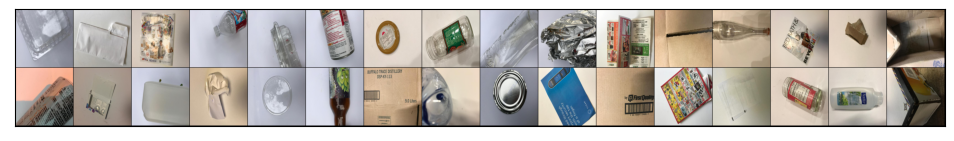

In [29]:
show_batch(train_dl)

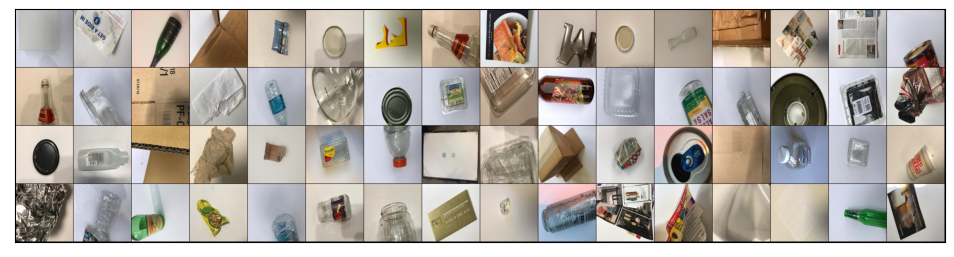

In [30]:
show_batch(val_dl)

Создадим базу модели:

In [31]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

ResNet50 для классификации изображений:

In [32]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
    
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_ResNet = ResNet()

## Портирование на GPU:

Используем GPU, если это возможно, если нет используем CPU для вычислений

In [33]:
def get_default_device():
    
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = get_default_device()
device

device(type='cpu')

Архетикрура сети

In [35]:
train_dl = DeviceDataLoader(train_dl, device);
val_dl = DeviceDataLoader(val_dl, device);
to_device(model_ResNet, device);

## Обучение модели:

Функция подгонки модели.

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
model_ResNet = to_device(ResNet(), device)

In [38]:
evaluate(model_ResNet, val_dl)

{'val_loss': 1.802977204322815, 'val_acc': 0.1927083283662796}

Приступим к обучению модели:

In [39]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 5.5e-5

history_ResNet = fit(num_epochs, lr, model_ResNet, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4670, val_loss: 1.2789, val_acc: 0.8333
Epoch 2: train_loss: 1.1826, val_loss: 1.1599, val_acc: 0.9219
Epoch 3: train_loss: 1.0980, val_loss: 1.1351, val_acc: 0.9288
Epoch 4: train_loss: 1.0734, val_loss: 1.1231, val_acc: 0.9549
Epoch 5: train_loss: 1.0624, val_loss: 1.1119, val_acc: 0.9618


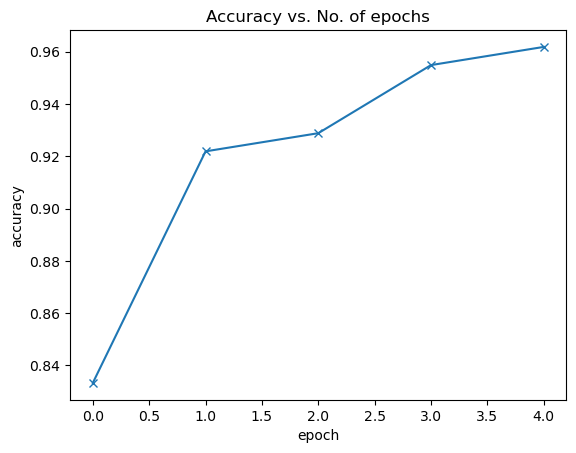

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history_ResNet)

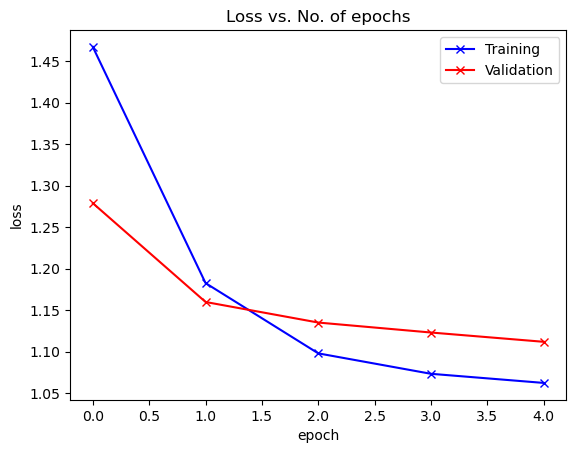

In [41]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history_ResNet)

## Визуализация прогнозов:

In [42]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Давайте посмотрим на прогнозы модели на тестовом наборе данных:

Label: metal , Predicted: metal


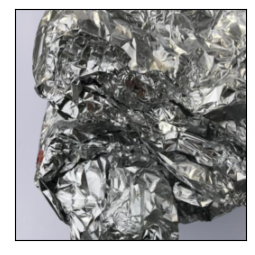

In [43]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

img, label = test_ds[27]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ResNet))


Label: paper , Predicted: paper


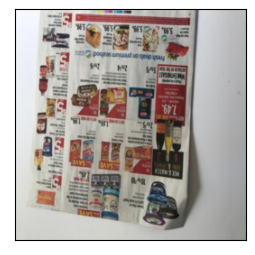

In [44]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ResNet))

Label: plastic , Predicted: plastic


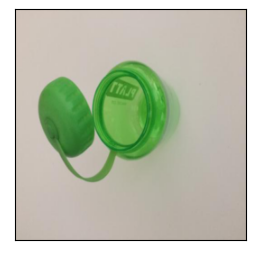

In [45]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[33]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ResNet))

Label: cardboard , Predicted: cardboard


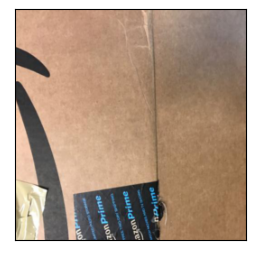

In [46]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[13]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ResNet))

Label: glass , Predicted: glass


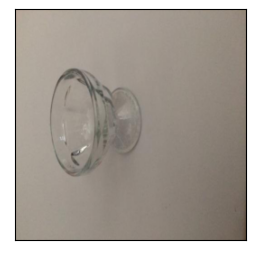

In [47]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ResNet))

Label: trash , Predicted: trash


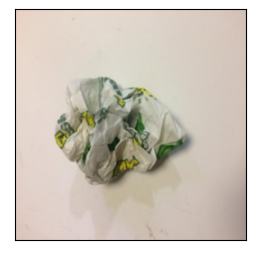

In [48]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[256]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ResNet))

Теперь посмотрим правильно ли сеть классифицирует изображения, загрузив изображения из интернета, которые сеть никогда не видела

In [128]:
from pathlib import Path
import urllib.request
def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))
    example_image = transformations(image)
    plt.figure(figsize=(3, 3))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, model_ResNet) + ".")

In [154]:
urllib.request.urlretrieve("https://media.istockphoto.com/id/1151594523/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%BA%D1%83%D1%81%D0%BE%D0%BA-%D0%BC%D1%8F%D1%82%D0%BE%D0%B9-%D1%84%D0%BE%D0%BB%D1%8C%D0%B3%D0%B8-%D0%BD%D0%B0-%D0%B1%D0%B5%D0%BB%D0%BE%D0%BC-%D1%84%D0%BE%D0%BD%D0%B5.jpg?s=1024x1024&w=is&k=20&c=3wgEOLEE5cItZ2WrB1Ar2P6GWuXdXnNT50XruOmQrII=", "foil.jpg")

urllib.request.urlretrieve("https://media.istockphoto.com/id/1089643450/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%BF%D1%83%D1%81%D1%82%D0%B0%D1%8F-%D0%B8-%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D0%B0%D1%8F-%D0%BA%D0%B0%D1%80%D1%82%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F-%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0.jpg?s=612x612&w=0&k=20&c=YEOJbyfpWkErVuWaEfOyJFAZk7llJkoBbXV977mFiLc=", "cardboard.jpg")    

urllib.request.urlretrieve("https://img.freepik.com/premium-photo/close-up-of-a-plastic-bottle-isolated-on-white-background_105428-3931.jpg?w=2000", "plastic.jpg") 

urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTmE6APuc5LZcch2xCGe74MqVvhb9nNIo0vVg&usqp=CAU", "wine-trash.jpg")

urllib.request.urlretrieve("https://images.freeimages.com/images/premium/previews/2338/23389873-news-folded-newspaper-on-white-isolated-background.jpg", "paper-trash.jpg")

urllib.request.urlretrieve("https://envato-shoebox-0.imgix.net/bead/db0e-a13d-47cd-8cfc-1517cccfe0f7/collage_2.jpg?auto=compress%2Cformat&fit=max&mark=https%3A%2F%2Felements-assets.envato.com%2Fstatic%2Fwatermark2.png&markalign=center%2Cmiddle&markalpha=18&w=700&s=1a2368fdb7ede058f86fc8a76b6bb12c", "mixed-trash.jpg")

('mixed-trash.jpg', <http.client.HTTPMessage at 0x1c00395d100>)

The image resembles metal.


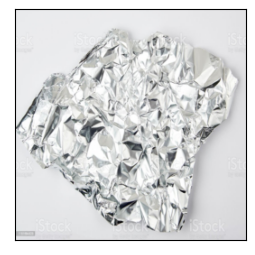

In [130]:
predict_external_image('foil.jpg')

The image resembles paper.


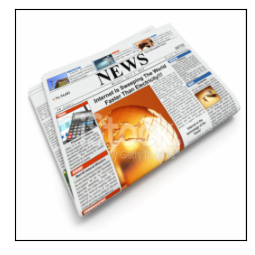

In [131]:
predict_external_image('paper-trash.jpg')

The image resembles cardboard.


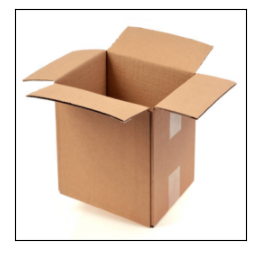

In [132]:
predict_external_image('cardboard.jpg')

The image resembles plastic.


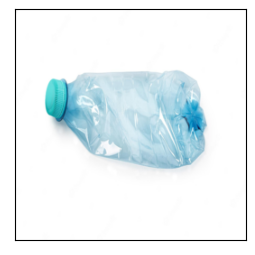

In [133]:
predict_external_image('plastic.jpg')

The image resembles glass.


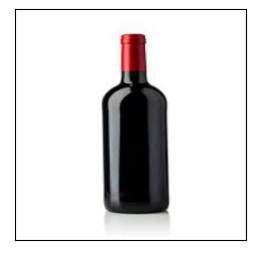

In [134]:
predict_external_image('wine-trash.jpg')

The image resembles trash.


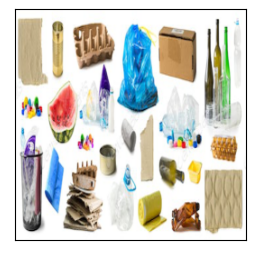

In [155]:
predict_external_image('mixed-trash.jpg')

Вывод: точность при 5 эпохах 96%

# Сеть GoogLeNet

Разделим данные на батчи 

In [49]:
random_seed = 42
torch.manual_seed(random_seed)

In [50]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [51]:
batch_size = 128

In [52]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [53]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

визуализируем батчи:

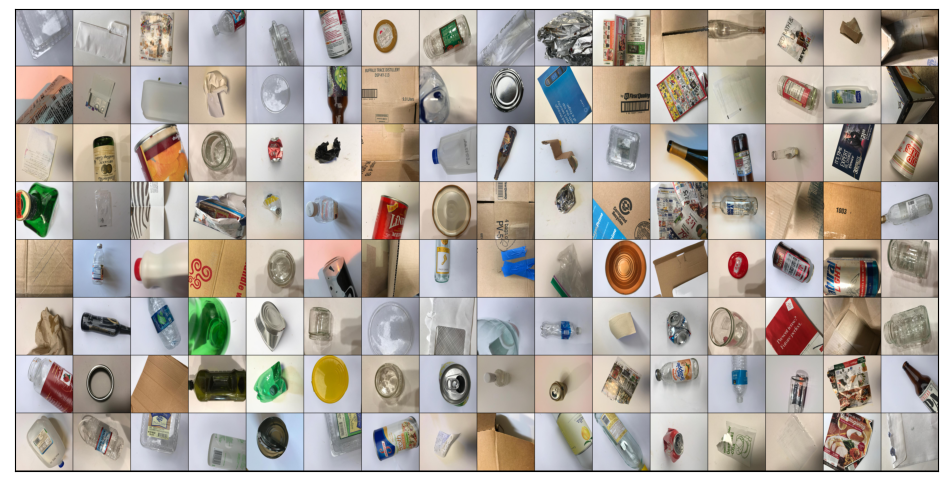

In [54]:
show_batch(train_dl)

Создадим базу модели

In [55]:
class googlenet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.googlenet(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes)) 
            
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_googlenet = googlenet()

C:\Users\Thermaltake\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
device = get_default_device()
device

device(type='cpu')

Архетиктура сети

In [57]:
train_dl = DeviceDataLoader(train_dl, device);
val_dl = DeviceDataLoader(val_dl, device);
to_device(model_googlenet, device);

Тренировка модели

In [58]:
model_googlenet = to_device(googlenet(), device)

In [59]:
evaluate(model_googlenet, val_dl)

{'val_loss': 1.7939324378967285, 'val_acc': 0.17613635957241058}

In [60]:
num_epochs = 7
opt_func = torch.optim.Adam
lr = 6e-4

history_googlenet = fit(num_epochs, lr, model_googlenet, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4964, val_loss: 1.3458, val_acc: 0.6591
Epoch 2: train_loss: 1.2001, val_loss: 1.2362, val_acc: 0.7955
Epoch 3: train_loss: 1.1098, val_loss: 1.1963, val_acc: 0.8750
Epoch 4: train_loss: 1.0790, val_loss: 1.2181, val_acc: 0.8352
Epoch 5: train_loss: 1.0680, val_loss: 1.2098, val_acc: 0.8636
Epoch 6: train_loss: 1.0577, val_loss: 1.1726, val_acc: 0.8807
Epoch 7: train_loss: 1.0551, val_loss: 1.1728, val_acc: 0.8920


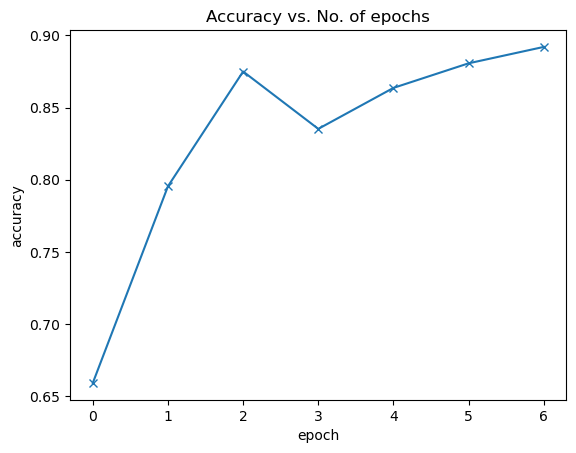

In [61]:
plot_accuracies(history_googlenet)

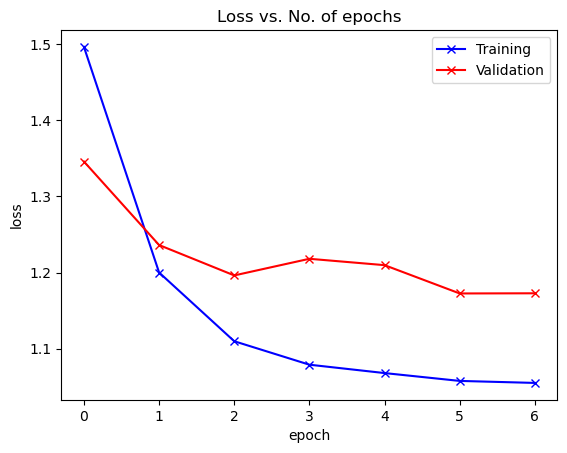

In [62]:
plot_losses(history_googlenet)

Визуализируем предсказания 

Label: metal , Predicted: metal


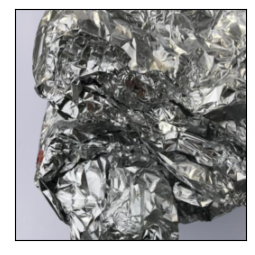

In [64]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

img, label = test_ds[27]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_googlenet))

Label: paper , Predicted: paper


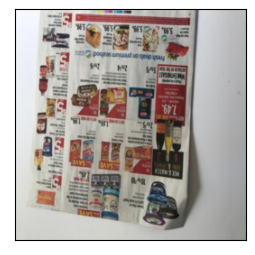

In [65]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_googlenet))

Label: plastic , Predicted: plastic


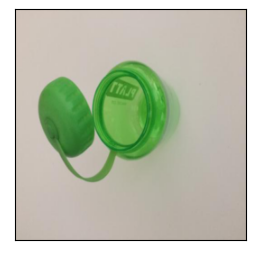

In [66]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[33]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_googlenet))

Label: cardboard , Predicted: cardboard


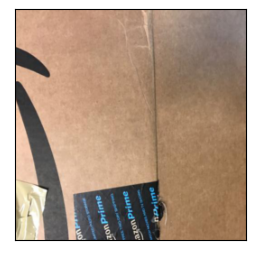

In [67]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[13]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_googlenet))

Label: glass , Predicted: glass


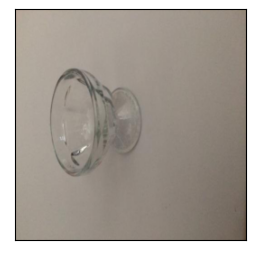

In [68]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_googlenet))

Label: trash , Predicted: trash


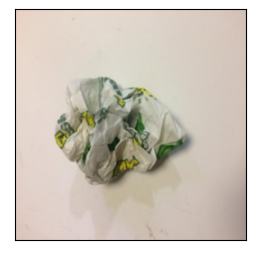

In [69]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[256]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_googlenet))

Теперь посмотрим правильно ли сеть классифицирует изображения, загрузив изображения из интернета, которые сеть никогда не видела

In [120]:
def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))
    example_image = transformations(image)
    plt.figure(figsize=(3, 3))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, model_googlenet) + ".")

In [152]:
urllib.request.urlretrieve("https://media.istockphoto.com/id/1151594523/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%BA%D1%83%D1%81%D0%BE%D0%BA-%D0%BC%D1%8F%D1%82%D0%BE%D0%B9-%D1%84%D0%BE%D0%BB%D1%8C%D0%B3%D0%B8-%D0%BD%D0%B0-%D0%B1%D0%B5%D0%BB%D0%BE%D0%BC-%D1%84%D0%BE%D0%BD%D0%B5.jpg?s=1024x1024&w=is&k=20&c=3wgEOLEE5cItZ2WrB1Ar2P6GWuXdXnNT50XruOmQrII=", "foil.jpg")

urllib.request.urlretrieve("https://media.istockphoto.com/id/1089643450/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%BF%D1%83%D1%81%D1%82%D0%B0%D1%8F-%D0%B8-%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D0%B0%D1%8F-%D0%BA%D0%B0%D1%80%D1%82%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F-%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0.jpg?s=612x612&w=0&k=20&c=YEOJbyfpWkErVuWaEfOyJFAZk7llJkoBbXV977mFiLc=", "cardboard.jpg")    

urllib.request.urlretrieve("https://img.freepik.com/premium-photo/close-up-of-a-plastic-bottle-isolated-on-white-background_105428-3931.jpg?w=2000", "plastic.jpg") 

urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTmE6APuc5LZcch2xCGe74MqVvhb9nNIo0vVg&usqp=CAU", "wine-trash.jpg")

urllib.request.urlretrieve("https://images.freeimages.com/images/premium/previews/2338/23389873-news-folded-newspaper-on-white-isolated-background.jpg", "paper-trash.jpg")

urllib.request.urlretrieve("https://envato-shoebox-0.imgix.net/bead/db0e-a13d-47cd-8cfc-1517cccfe0f7/collage_2.jpg?auto=compress%2Cformat&fit=max&mark=https%3A%2F%2Felements-assets.envato.com%2Fstatic%2Fwatermark2.png&markalign=center%2Cmiddle&markalpha=18&w=700&s=1a2368fdb7ede058f86fc8a76b6bb12c", "mixed-trash.jpg")

('mixed-trash.jpg', <http.client.HTTPMessage at 0x1c01c0169d0>)

The image resembles metal.


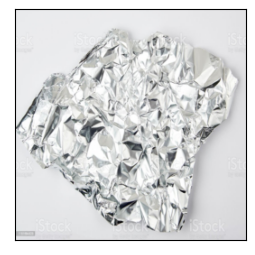

In [122]:
predict_external_image('foil.jpg')

The image resembles paper.


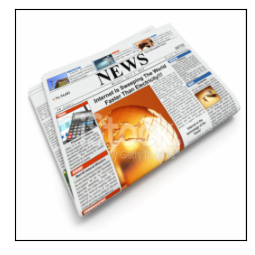

In [123]:
predict_external_image('paper-trash.jpg')

The image resembles cardboard.


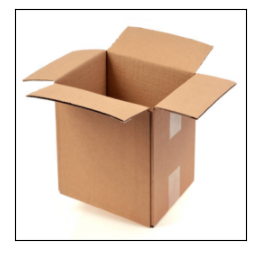

In [124]:
predict_external_image('cardboard.jpg')

The image resembles plastic.


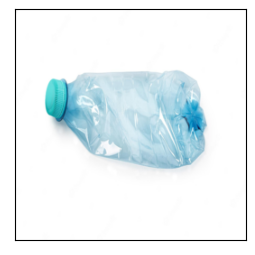

In [125]:
predict_external_image('plastic.jpg')

The image resembles glass.


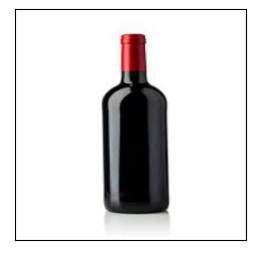

In [126]:
predict_external_image('wine-trash.jpg')

The image resembles trash.


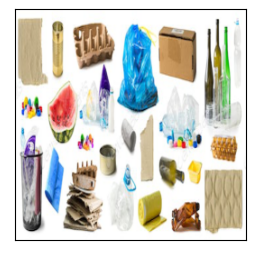

In [153]:
predict_external_image('mixed-trash.jpg')

Вывод: Точность при 7 эпохах 89%

# Сеть VGG

Разделим данные на батчи 

In [70]:
random_seed = 42
torch.manual_seed(random_seed)

In [71]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [72]:
batch_size = 64

In [73]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

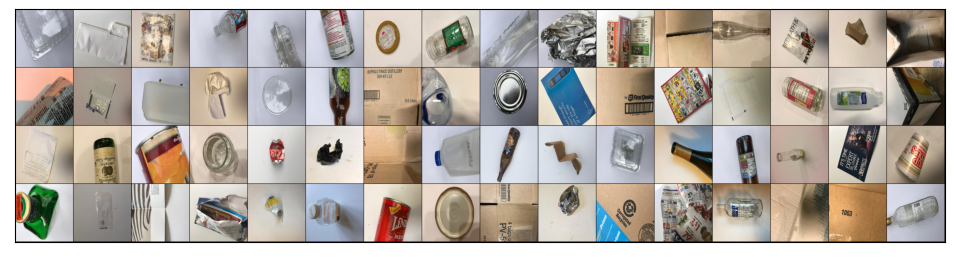

In [74]:
show_batch(train_dl)

In [75]:
class vgg(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg19(pretrained=True)
        number_features = self.network.classifier[6].in_features 
        features = list(self.network.classifier.children())[:-1] 
        features.extend([torch.nn.Linear(number_features, 6)]) 
        self.network.classifier = torch.nn.Sequential(*features) 
            
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_vgg = vgg()


C:\Users\Thermaltake\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
device = get_default_device()
device

device(type='cpu')

Архетиктура сети

In [77]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model_vgg, device)

vgg(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Co

In [78]:
model_vgg = to_device(vgg(), device)

In [79]:
evaluate(model_vgg, val_dl)

{'val_loss': 1.774692177772522, 'val_acc': 0.2473958283662796}

Тренировка модели

In [80]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history_vgg = fit(num_epochs, lr, model_vgg, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4816, val_loss: 1.3184, val_acc: 0.6445
Epoch 2: train_loss: 1.2906, val_loss: 1.2838, val_acc: 0.6940
Epoch 3: train_loss: 1.2545, val_loss: 1.2841, val_acc: 0.7201
Epoch 4: train_loss: 1.2165, val_loss: 1.2816, val_acc: 0.6654
Epoch 5: train_loss: 1.1803, val_loss: 1.2349, val_acc: 0.7773
Epoch 6: train_loss: 1.1608, val_loss: 1.2833, val_acc: 0.7279
Epoch 7: train_loss: 1.1423, val_loss: 1.2143, val_acc: 0.8138
Epoch 8: train_loss: 1.1091, val_loss: 1.2050, val_acc: 0.8594


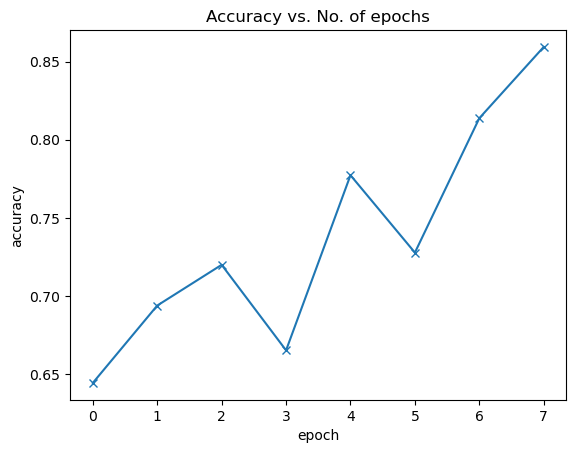

In [81]:
plot_accuracies(history_vgg)

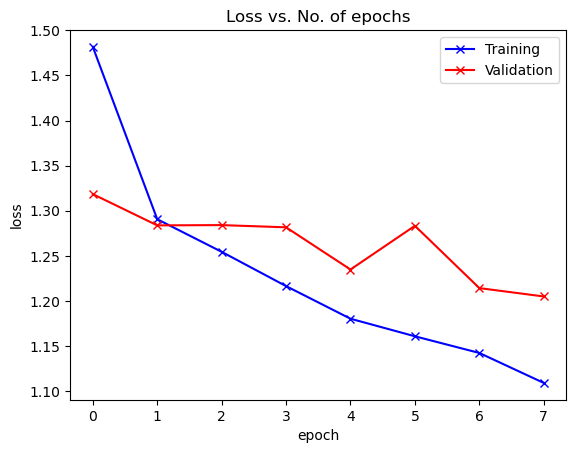

In [82]:
plot_losses(history_vgg)

Визуализируем прогнозы

Label: metal , Predicted: metal


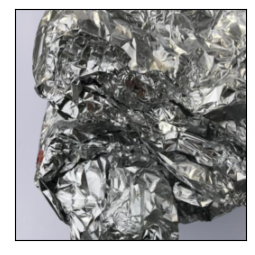

In [83]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

img, label = test_ds[27]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_vgg))

Label: paper , Predicted: paper


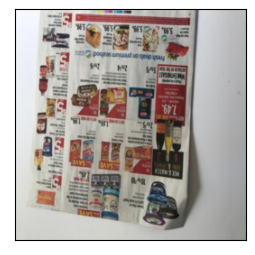

In [84]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_vgg))

Label: plastic , Predicted: plastic


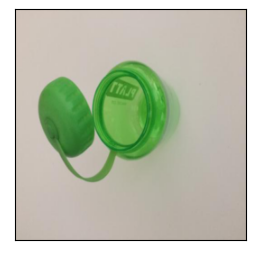

In [85]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[33]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_vgg))

Label: cardboard , Predicted: cardboard


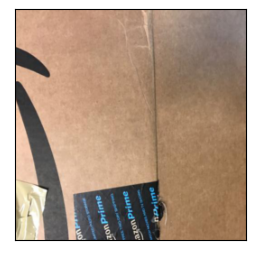

In [86]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[13]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_vgg))

Label: glass , Predicted: glass


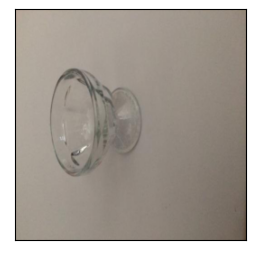

In [87]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[16]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_vgg))

Label: trash , Predicted: plastic


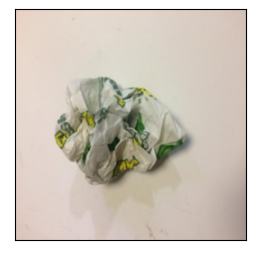

In [88]:
plt.figure(figsize=(3, 3))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img, label = test_ds[256]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_vgg))

Теперь посмотрим правильно ли сеть классифицирует изображения, загрузив изображения из интернета, которые сеть никогда не видела

In [144]:
def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))
    example_image = transformations(image)
    plt.figure(figsize=(3, 3))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, model_vgg) + ".")

In [145]:
urllib.request.urlretrieve("https://media.istockphoto.com/id/1151594523/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%BA%D1%83%D1%81%D0%BE%D0%BA-%D0%BC%D1%8F%D1%82%D0%BE%D0%B9-%D1%84%D0%BE%D0%BB%D1%8C%D0%B3%D0%B8-%D0%BD%D0%B0-%D0%B1%D0%B5%D0%BB%D0%BE%D0%BC-%D1%84%D0%BE%D0%BD%D0%B5.jpg?s=1024x1024&w=is&k=20&c=3wgEOLEE5cItZ2WrB1Ar2P6GWuXdXnNT50XruOmQrII=", "foil.jpg")

urllib.request.urlretrieve("https://media.istockphoto.com/id/1089643450/ru/%D1%84%D0%BE%D1%82%D0%BE/%D0%BF%D1%83%D1%81%D1%82%D0%B0%D1%8F-%D0%B8-%D0%BE%D1%82%D0%BA%D1%80%D1%8B%D1%82%D0%B0%D1%8F-%D0%BA%D0%B0%D1%80%D1%82%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F-%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0.jpg?s=612x612&w=0&k=20&c=YEOJbyfpWkErVuWaEfOyJFAZk7llJkoBbXV977mFiLc=", "cardboard.jpg")    

urllib.request.urlretrieve("https://img.freepik.com/premium-photo/close-up-of-a-plastic-bottle-isolated-on-white-background_105428-3931.jpg?w=2000", "plastic.jpg") 

urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTmE6APuc5LZcch2xCGe74MqVvhb9nNIo0vVg&usqp=CAU", "wine-trash.jpg")

urllib.request.urlretrieve("https://images.freeimages.com/images/premium/previews/2338/23389873-news-folded-newspaper-on-white-isolated-background.jpg", "paper-trash.jpg")

urllib.request.urlretrieve("https://envato-shoebox-0.imgix.net/bead/db0e-a13d-47cd-8cfc-1517cccfe0f7/collage_2.jpg?auto=compress%2Cformat&fit=max&mark=https%3A%2F%2Felements-assets.envato.com%2Fstatic%2Fwatermark2.png&markalign=center%2Cmiddle&markalpha=18&w=700&s=1a2368fdb7ede058f86fc8a76b6bb12c", "mixed-trash.jpg")

('mixed-trash.jpg', <http.client.HTTPMessage at 0x1c01804ca00>)

The image resembles metal.


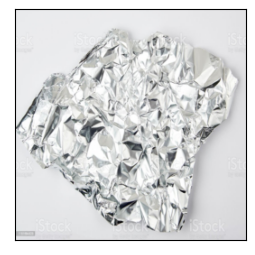

In [146]:
predict_external_image('foil.jpg')

The image resembles paper.


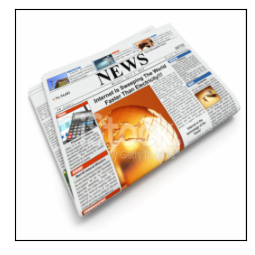

In [147]:
predict_external_image('paper-trash.jpg')

The image resembles cardboard.


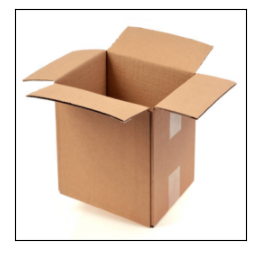

In [148]:
predict_external_image('cardboard.jpg')

The image resembles plastic.


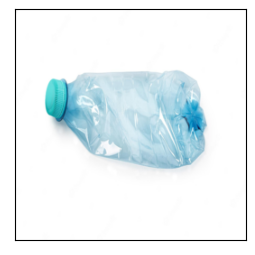

In [149]:
predict_external_image('plastic.jpg')

The image resembles glass.


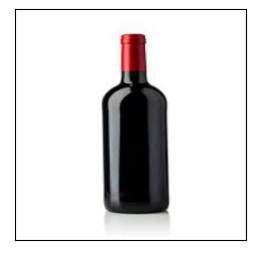

In [150]:
predict_external_image('wine-trash.jpg')

The image resembles trash.


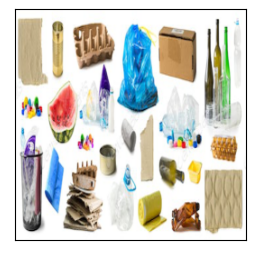

In [151]:
predict_external_image('mixed-trash.jpg')

Вывод: Точность при 8 эпохах 85%